In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v6 import Autoencoder
from tools.GRU_AR_v7 import AR_RNN_GRU as AR_RNN
# from tools.LSTM_AR_v1 import AR_RNN_LSTM as AR_RNN
from tools.AEGRU_AR_v1 import AR_AERNN_GRU
from tools.trainAERNN import trainAERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpoin?tAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-01-18 08:53:06.948765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 08:53:06.949196: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 08:53:07.009325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 08:53:07.009747: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 08:53:07.010046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_059'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_AERNN_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    try:
        stateful = params_rnn_dict['stateful']
    except:
        print("'stateful' not present in RNN_specific_data, set to True.")
        stateful = True
    try:
        use_learnable_state = params_rnn_dict['use_learnable_state']
    except:
        print("'use_learnable_state' not present in RNN_specific_data, set to False.")
        use_learnable_state = False
    try:
        use_weights_post_dense = params_rnn_dict['use_weights_post_dense']
    except:
        print("'use_weights_post_dense' not present in RNN_specific_data, set to False.")
        use_weights_post_dense = False
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_AErnn_000'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_rnn_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None
    if 'freeze_layers' in tparams_dict.keys():
        freeze_layers = tparams_dict['freeze_layers']
    else:
        freeze_layers = None
    if 'clipnorm' in tparams_dict.keys():
        clipnorm = tparams_dict['clipnorm']
    else:
        clipnorm = None
    


# reading stddev
with open(dir_name_rnn + '/final_net/final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
# stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_arr_rnn = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx
try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to True.")
    use_ae_data = True

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in RNN_specific_data, set to True.")
    ae_data_with_params = True

print('dir_name_AR_AErnn:', dir_name_ARrnn)
print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state_mat = params_dict['init_state_mat']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']
    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [13]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

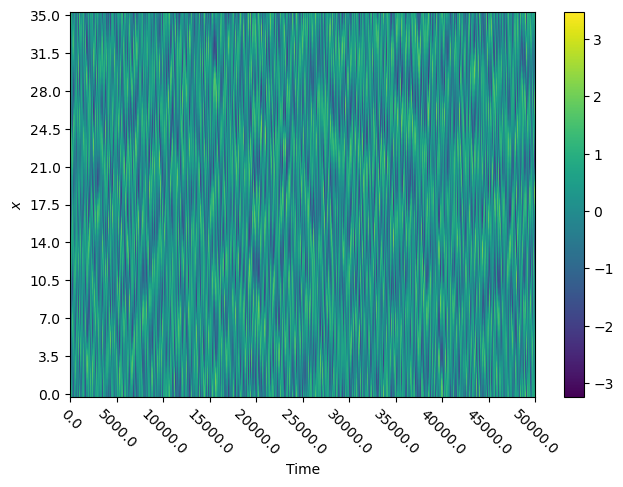

In [14]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [15]:
# # dealing with normalizing the data before feeding into autoencoder
# if use_ae_data == True:
#     if normalizeforae_flag == True:
#         for i in range(numpoints_xgrid):
#             all_data[:, i] -= normalization_constant_arr_aedata[0, i]
#             all_data[:, i] /= normalization_constant_arr_aedata[1, i]

#     if ae_data_with_params == False:
#         all_data = all_data[:, 0:numpoints_xgrid]
# else:
#     # using raw data, neglecting the params attached (if any)
#     all_data = all_data[:, 0:numpoints_xgrid]

if use_ae_data == True and ae_data_with_params == False:
    all_data = all_data[:, 0:numpoints_xgrid]
else:
    all_data = all_data[:, 0:numpoints_xgrid]

# Autoencoder

In [16]:
# if use_ae_data == True:
#     load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
#     wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [17]:
# if use_ae_data == True:
#     ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
#     ae_net.load_weights_from_file(wt_file)

# GRU

In [18]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = np.array([5, 10, 30, 50, 70])*dt_rnn/np.mean(lyapunov_time_arr)
    num_timesteps_warmup = 1*np.mean(lyapunov_time_arr)/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = T_sample_input
    skip_intermediate = 'full sample'
    stateful = True
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':AR_RNN.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
        'stateful':stateful,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [19]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [
        [5e-5],
        [5e-5],
        [1e-5],
        [1e-6],
        [5e-7],
    ]
    epochs = [
        [1000],
        [1000],
        [1000],
        [1000],
        [1000],
    ]
    patience = [
        [30],
        [30],
        [30],
        [50],
        [50],
    ] # parameter for early stopping
    min_delta = 1e-5  # parameter for early stopping
    lambda_reg = 5e-7  # weight for regularizer
    covmat_lmda = 1e-5  # weight for the covmat loss

    if loss_weights is None:
        loss_weights = 1.0
        
    freeze_layers = [
        [],
        [],
        [],
        [],
        [],
    ]
    
    clipnorm = None #1.0
    batch_size = 32
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
        'stddev':stddev,
        'covmat_lmda':covmat_lmda,
        'freeze_layers':freeze_layers,
        'clipnorm':clipnorm,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr_rnn],
    )

In [20]:
if behaviour == 'initialiseAndTrainFromScratch':
    load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
    wt_file_rnn = dir_name_rnn+'/final_net/final_net_gru_weights.h5'
    
    load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
    wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 5 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : None


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 5e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
76/76 [==============================] - ETA: 0s - loss: 0.0058 - mse: 4.5927e-04 - NMSE: 0.0041 - covmat_fro_loss: 2.5610e-04 - global_gradnorm: 0.4597 - tot_time: 0h 0m 25.2s

Epoch 1: val_NMSE improved from inf to 0.00403, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/check

Epoch 11/1000
76/76 [==============================] - ETA: 0s - loss: 0.0045 - mse: 3.2355e-04 - NMSE: 0.0029 - covmat_fro_loss: 2.1956e-04 - global_gradnorm: 0.3427 - tot_time: 0h 1m 57.8s

Epoch 11: val_NMSE improved from 0.00305 to 0.00294, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 10s 127ms/step - loss: 0.0045 - mse: 3.2355e-04 - NMSE: 0.0029 - covmat_fro_loss: 2.1971e-04 - global_gradnorm: 0.3429 - val_loss: 0.0045 - val_mse: 3.2716e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/1000
76/76 [==============================] - ETA: 0s - loss: 0.0044 - mse: 3.1410e-04 - NMSE: 0.0028 - covmat_fro_loss: 2.1641e-04 - global_gradnorm: 0.3196 - tot_time: 0h 2m 7.2s

Epoch 12:

Epoch 23/1000
76/76 [==============================] - ETA: 0s - loss: 0.0039 - mse: 2.6777e-04 - NMSE: 0.0024 - covmat_fro_loss: 2.0135e-04 - global_gradnorm: 0.2722 - tot_time: 0h 3m 47.5s

Epoch 23: val_NMSE did not improve from 0.00257
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 117ms/step - loss: 0.0039 - mse: 2.6777e-04 - NMSE: 0.0024 - covmat_fro_loss: 2.0125e-04 - global_gradnorm: 0.2721 - val_loss: 0.0043 - val_mse: 3.1324e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 24/1000
76/76 [==============================] - ETA: 0s - loss: 0.0040 - mse: 2.7959e-04 - NMSE: 0.0025 - covmat_fro_loss: 2.0552e-04 - global_gradnorm: 0.2835 - tot_time: 0h 3m 56.5s

Epoch 24: val_NMSE did not improve from 0.00257
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn

Epoch 35/1000
76/76 [==============================] - ETA: 0s - loss: 0.0037 - mse: 2.5588e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9737e-04 - global_gradnorm: 0.2598 - tot_time: 0h 5m 34.4s

Epoch 35: val_NMSE did not improve from 0.00248
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 114ms/step - loss: 0.0037 - mse: 2.5588e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9746e-04 - global_gradnorm: 0.2608 - val_loss: 0.0041 - val_mse: 2.9431e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 36/1000
76/76 [==============================] - ETA: 0s - loss: 0.0037 - mse: 2.4789e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.9431e-04 - global_gradnorm: 0.2526 - tot_time: 0h 5m 42.8s

Epoch 36: val_NMSE did not improve from 0.00248
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn

Epoch 47/1000
76/76 [==============================] - ETA: 0s - loss: 0.0035 - mse: 2.3499e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8978e-04 - global_gradnorm: 0.2310 - tot_time: 0h 7m 19.8s

Epoch 47: val_NMSE did not improve from 0.00232
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 115ms/step - loss: 0.0035 - mse: 2.3499e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8985e-04 - global_gradnorm: 0.2309 - val_loss: 0.0038 - val_mse: 2.7603e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 48/1000
76/76 [==============================] - ETA: 0s - loss: 0.0035 - mse: 2.3268e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8932e-04 - global_gradnorm: 0.2339 - tot_time: 0h 7m 28.6s

Epoch 48: val_NMSE improved from 0.00232 to 0.00229, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

Epoch 59/1000
76/76 [==============================] - ETA: 0s - loss: 0.0033 - mse: 2.1824e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8319e-04 - global_gradnorm: 0.2175 - tot_time: 0h 9m 7.3s

Epoch 59: val_NMSE did not improve from 0.00215
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 115ms/step - loss: 0.0033 - mse: 2.1824e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8322e-04 - global_gradnorm: 0.2173 - val_loss: 0.0036 - val_mse: 2.5216e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 60/1000
76/76 [==============================] - ETA: 0s - loss: 0.0033 - mse: 2.1668e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8297e-04 - global_gradnorm: 0.2182 - tot_time: 0h 9m 16.0s

Epoch 60: val_NMSE did not improve from 0.00215
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/

Epoch 71/1000
76/76 [==============================] - ETA: 0s - loss: 0.0032 - mse: 2.1649e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.8277e-04 - global_gradnorm: 0.2186 - tot_time: 0h 10m 53.4s

Epoch 71: val_NMSE did not improve from 0.00214
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 116ms/step - loss: 0.0032 - mse: 2.1649e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.8298e-04 - global_gradnorm: 0.2192 - val_loss: 0.0036 - val_mse: 2.5918e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 72/1000
76/76 [==============================] - ETA: 0s - loss: 0.0031 - mse: 2.0526e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7839e-04 - global_gradnorm: 0.1941 - tot_time: 0h 11m 2.2s

Epoch 72: val_NMSE did not improve from 0.00214
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rn

Epoch 83/1000
76/76 [==============================] - ETA: 0s - loss: 0.0030 - mse: 2.0181e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7702e-04 - global_gradnorm: 0.1987 - tot_time: 0h 12m 40.6s

Epoch 83: val_NMSE did not improve from 0.00204
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 118ms/step - loss: 0.0030 - mse: 2.0181e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7697e-04 - global_gradnorm: 0.1985 - val_loss: 0.0034 - val_mse: 2.4183e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 84/1000
76/76 [==============================] - ETA: 0s - loss: 0.0030 - mse: 1.9773e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7581e-04 - global_gradnorm: 0.1909 - tot_time: 0h 12m 49.4s

Epoch 84: val_NMSE improved from 0.00204 to 0.00201, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_r

Epoch 95/1000
76/76 [==============================] - ETA: 0s - loss: 0.0029 - mse: 1.8950e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.7243e-04 - global_gradnorm: 0.1822 - tot_time: 0h 14m 25.9s

Epoch 95: val_NMSE did not improve from 0.00193
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 113ms/step - loss: 0.0029 - mse: 1.8950e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.7245e-04 - global_gradnorm: 0.1823 - val_loss: 0.0032 - val_mse: 2.2002e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 96/1000
76/76 [==============================] - ETA: 0s - loss: 0.0029 - mse: 1.9280e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.7360e-04 - global_gradnorm: 0.1844 - tot_time: 0h 14m 34.3s

Epoch 96: val_NMSE did not improve from 0.00193
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_r

Epoch 107/1000
76/76 [==============================] - ETA: 0s - loss: 0.0028 - mse: 1.8187e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6903e-04 - global_gradnorm: 0.1729 - tot_time: 0h 16m 10.9s

Epoch 107: val_NMSE did not improve from 0.00191
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 114ms/step - loss: 0.0028 - mse: 1.8187e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6917e-04 - global_gradnorm: 0.1735 - val_loss: 0.0032 - val_mse: 2.2881e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 108/1000
76/76 [==============================] - ETA: 0s - loss: 0.0029 - mse: 1.9307e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.7379e-04 - global_gradnorm: 0.1848 - tot_time: 0h 16m 19.4s

Epoch 108: val_NMSE did not improve from 0.00191
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 119/1000
76/76 [==============================] - ETA: 0s - loss: 0.0028 - mse: 1.8625e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.7086e-04 - global_gradnorm: 0.1763 - tot_time: 0h 17m 56.8s

Epoch 119: val_NMSE did not improve from 0.00182
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 115ms/step - loss: 0.0028 - mse: 1.8625e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.7094e-04 - global_gradnorm: 0.1767 - val_loss: 0.0032 - val_mse: 2.2694e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 120/1000
76/76 [==============================] - ETA: 0s - loss: 0.0027 - mse: 1.7621e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6660e-04 - global_gradnorm: 0.1759 - tot_time: 0h 18m 5.4s

Epoch 120: val_NMSE did not improve from 0.00182
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 131/1000
76/76 [==============================] - ETA: 0s - loss: 0.0027 - mse: 1.7695e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6695e-04 - global_gradnorm: 0.1725 - tot_time: 0h 19m 41.6s

Epoch 131: val_NMSE did not improve from 0.00177
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 114ms/step - loss: 0.0027 - mse: 1.7695e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6697e-04 - global_gradnorm: 0.1720 - val_loss: 0.0030 - val_mse: 2.1310e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 132/1000
76/76 [==============================] - ETA: 0s - loss: 0.0028 - mse: 1.8019e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6834e-04 - global_gradnorm: 0.1750 - tot_time: 0h 19m 50.3s

Epoch 132: val_NMSE did not improve from 0.00177
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

76/76 [==============================] - ETA: 0s - loss: 0.0027 - mse: 1.7356e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6558e-04 - global_gradnorm: 0.1732 - tot_time: 0h 21m 25.5s

Epoch 143: val_NMSE did not improve from 0.00177
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 114ms/step - loss: 0.0027 - mse: 1.7356e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6564e-04 - global_gradnorm: 0.1732 - val_loss: 0.0031 - val_mse: 2.2654e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 144/1000
76/76 [==============================] - ETA: 0s - loss: 0.0027 - mse: 1.7497e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6632e-04 - global_gradnorm: 0.1666 - tot_time: 0h 21m 34.2s

Epoch 144: val_NMSE did not improve from 0.00177
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 155/1000
76/76 [==============================] - ETA: 0s - loss: 0.0026 - mse: 1.6819e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6309e-04 - global_gradnorm: 0.1615 - tot_time: 0h 23m 9.6s

Epoch 155: val_NMSE did not improve from 0.00176
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 115ms/step - loss: 0.0026 - mse: 1.6819e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6308e-04 - global_gradnorm: 0.1615 - val_loss: 0.0029 - val_mse: 1.9900e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 156/1000
76/76 [==============================] - ETA: 0s - loss: 0.0026 - mse: 1.6837e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6295e-04 - global_gradnorm: 0.1663 - tot_time: 0h 23m 18.5s

Epoch 156: val_NMSE did not improve from 0.00176
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 167/1000
76/76 [==============================] - ETA: 0s - loss: 0.0026 - mse: 1.6563e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6202e-04 - global_gradnorm: 0.1561 - tot_time: 0h 24m 54.8s

Epoch 167: val_NMSE did not improve from 0.00173
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 115ms/step - loss: 0.0026 - mse: 1.6563e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6210e-04 - global_gradnorm: 0.1566 - val_loss: 0.0028 - val_mse: 1.9688e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 168/1000
76/76 [==============================] - ETA: 0s - loss: 0.0026 - mse: 1.6340e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6075e-04 - global_gradnorm: 0.1577 - tot_time: 0h 25m 3.6s

Epoch 168: val_NMSE improved from 0.00173 to 0.00171, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/A

Epoch 179/1000
76/76 [==============================] - ETA: 0s - loss: 0.0025 - mse: 1.6112e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5989e-04 - global_gradnorm: 0.1499 - tot_time: 0h 26m 39.1s

Epoch 179: val_NMSE did not improve from 0.00165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 114ms/step - loss: 0.0025 - mse: 1.6112e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6002e-04 - global_gradnorm: 0.1502 - val_loss: 0.0029 - val_mse: 2.0874e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 180/1000
76/76 [==============================] - ETA: 0s - loss: 0.0026 - mse: 1.6485e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6155e-04 - global_gradnorm: 0.1534 - tot_time: 0h 26m 47.6s

Epoch 180: val_NMSE did not improve from 0.00165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

76/76 [==============================] - ETA: 0s - loss: 0.0025 - mse: 1.5907e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5924e-04 - global_gradnorm: 0.1464 - tot_time: 0h 28m 22.3s

Epoch 191: val_NMSE did not improve from 0.00165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 115ms/step - loss: 0.0025 - mse: 1.5907e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5936e-04 - global_gradnorm: 0.1465 - val_loss: 0.0028 - val_mse: 1.9149e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 192/1000
76/76 [==============================] - ETA: 0s - loss: 0.0025 - mse: 1.6000e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5928e-04 - global_gradnorm: 0.1474 - tot_time: 0h 28m 31.0s

Epoch 192: val_NMSE did not improve from 0.00165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

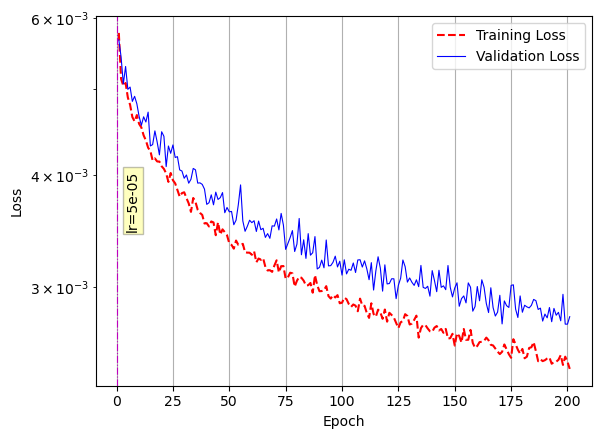

<Figure size 640x480 with 0 Axes>

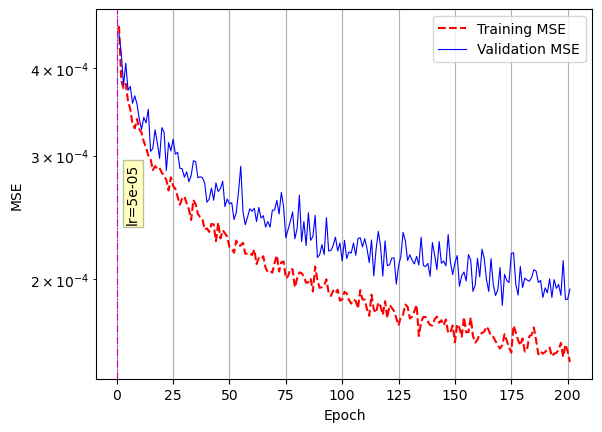

<Figure size 640x480 with 0 Axes>

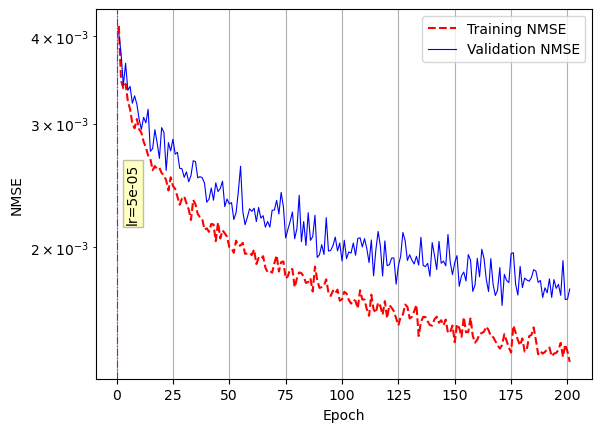

<Figure size 640x480 with 0 Axes>

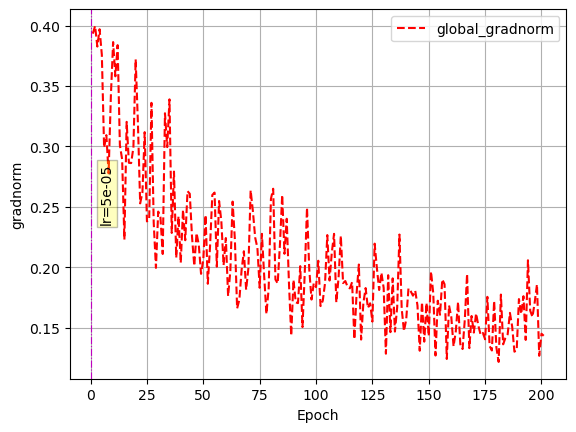



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 10 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.31974749565124516


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 5e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
71/71 [==============================] - ETA: 0s - loss: 0.0052 - mse: 5.0837e-04 - NMSE: 0.0046 - covmat_fro_loss: 4.9508e-04 - global_gradnorm: 0.3194 - tot_time: 0h 0m 38.6s

Epoch 1: val_NMSE improved from inf to 0.00377, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 11s 149ms/step - loss: 0.0042 - mse: 3.7685e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.3050e-04 - global_gradnorm: 0.3188 - val_loss: 0.0041 - val_mse: 3.7054e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/1000
71/71 [==============================] - ETA: 0s - loss: 0.0042 - mse: 3.7941e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.3231e-04 - global_gradnorm: 0.3184 - tot_time: 0h 2m 31.3s

Epoch 12: val_NMSE did not improve from 0.00333
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 140ms/step - loss: 0.0042 - mse: 3.7941e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.3225e-04 - global_gradnorm: 0.3184 - val_loss: 0.0043

Epoch 23/1000
71/71 [==============================] - ETA: 0s - loss: 0.0039 - mse: 3.4796e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.1621e-04 - global_gradnorm: 0.3170 - tot_time: 0h 4m 23.8s

Epoch 23: val_NMSE did not improve from 0.00318
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 143ms/step - loss: 0.0039 - mse: 3.4796e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.1690e-04 - global_gradnorm: 0.3170 - val_loss: 0.0044 - val_mse: 4.0549e-04 - val_NMSE: 0.0036 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 24/1000
71/71 [==============================] - ETA: 0s - loss: 0.0038 - mse: 3.3131e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.0642e-04 - global_gradnorm: 0.3136 - tot_time: 0h 4m 33.8s

Epoch 24: val_NMSE did not improve from 0.00318
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_r

Epoch 35/1000
71/71 [==============================] - ETA: 0s - loss: 0.0036 - mse: 3.0834e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.9173e-04 - global_gradnorm: 0.3112 - tot_time: 0h 6m 25.5s

Epoch 35: val_NMSE improved from 0.00310 to 0.00303, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 11s 148ms/step - loss: 0.0036 - mse: 3.0834e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.9157e-04 - global_gradnorm: 0.3113 - val_loss: 0.0039 - val_mse: 3.3634e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 36/1000
71/71 [==============================] - ETA: 0s - loss: 0.0035 - mse: 2.9765e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.8607e-04 - global_gradnorm: 0.3065 - tot_time: 0h 6m 36.1s

Epoch 

Epoch 47/1000
71/71 [==============================] - ETA: 0s - loss: 0.0034 - mse: 2.8035e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.7558e-04 - global_gradnorm: 0.2865 - tot_time: 0h 8m 28.0s

Epoch 47: val_NMSE did not improve from 0.00284
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 142ms/step - loss: 0.0034 - mse: 2.8035e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.7546e-04 - global_gradnorm: 0.2866 - val_loss: 0.0037 - val_mse: 3.1941e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 48/1000
71/71 [==============================] - ETA: 0s - loss: 0.0036 - mse: 2.9905e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.8674e-04 - global_gradnorm: 0.3075 - tot_time: 0h 8m 37.9s

Epoch 48: val_NMSE did not improve from 0.00284
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_r

Epoch 59/1000
71/71 [==============================] - ETA: 0s - loss: 0.0034 - mse: 2.8235e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.7710e-04 - global_gradnorm: 0.2937 - tot_time: 0h 10m 29.9s

Epoch 59: val_NMSE did not improve from 0.00275
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 145ms/step - loss: 0.0034 - mse: 2.8235e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.7717e-04 - global_gradnorm: 0.2929 - val_loss: 0.0038 - val_mse: 3.2930e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 60/1000
71/71 [==============================] - ETA: 0s - loss: 0.0035 - mse: 2.8658e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.8034e-04 - global_gradnorm: 0.2964 - tot_time: 0h 10m 39.9s

Epoch 60: val_NMSE did not improve from 0.00275
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

Epoch 71/1000
71/71 [==============================] - ETA: 0s - loss: 0.0033 - mse: 2.6920e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.6873e-04 - global_gradnorm: 0.2904 - tot_time: 0h 12m 30.8s

Epoch 71: val_NMSE did not improve from 0.00269
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 141ms/step - loss: 0.0033 - mse: 2.6920e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.6876e-04 - global_gradnorm: 0.2898 - val_loss: 0.0038 - val_mse: 3.3206e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 72/1000
71/71 [==============================] - ETA: 0s - loss: 0.0033 - mse: 2.6975e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.6887e-04 - global_gradnorm: 0.2782 - tot_time: 0h 12m 40.8s

Epoch 72: val_NMSE did not improve from 0.00269
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 2.5758e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.6125e-04 - global_gradnorm: 0.2789 - tot_time: 0h 14m 31.9s

Epoch 83: val_NMSE did not improve from 0.00269
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 142ms/step - loss: 0.0032 - mse: 2.5758e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.6123e-04 - global_gradnorm: 0.2785 - val_loss: 0.0036 - val_mse: 3.1021e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 84/1000
71/71 [==============================] - ETA: 0s - loss: 0.0033 - mse: 2.6380e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.6511e-04 - global_gradnorm: 0.2940 - tot_time: 0h 14m 41.8s

Epoch 84: val_NMSE did not improve from 0.00269
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_03

Epoch 95/1000
71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 2.5273e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.5862e-04 - global_gradnorm: 0.2732 - tot_time: 0h 16m 33.1s

Epoch 95: val_NMSE did not improve from 0.00264
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 142ms/step - loss: 0.0032 - mse: 2.5273e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.5867e-04 - global_gradnorm: 0.2730 - val_loss: 0.0037 - val_mse: 3.1635e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 96/1000
71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 2.4566e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.5352e-04 - global_gradnorm: 0.2709 - tot_time: 0h 16m 43.1s

Epoch 96: val_NMSE did not improve from 0.00264
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 2.4901e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.5579e-04 - global_gradnorm: 0.2634 - tot_time: 0h 18m 32.0s

Epoch 107: val_NMSE did not improve from 0.00264
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 139ms/step - loss: 0.0032 - mse: 2.4901e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.5573e-04 - global_gradnorm: 0.2632 - val_loss: 0.0036 - val_mse: 2.9912e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 108/1000
71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 2.4390e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.5197e-04 - global_gradnorm: 0.2772 - tot_time: 0h 18m 41.9s

Epoch 108: val_NMSE improved from 0.00264 to 0.00263, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/ch

Epoch 119/1000
71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 2.3204e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.4424e-04 - global_gradnorm: 0.2431 - tot_time: 0h 20m 34.3s

Epoch 119: val_NMSE did not improve from 0.00250
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 137ms/step - loss: 0.0030 - mse: 2.3204e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.4441e-04 - global_gradnorm: 0.2436 - val_loss: 0.0035 - val_mse: 2.9745e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 120/1000
71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 2.4793e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.5467e-04 - global_gradnorm: 0.2680 - tot_time: 0h 20m 44.2s

Epoch 120: val_NMSE did not improve from 0.00250
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

Epoch 131/1000
71/71 [==============================] - ETA: 0s - loss: 0.0029 - mse: 2.2344e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.3756e-04 - global_gradnorm: 0.2357 - tot_time: 0h 22m 32.8s

Epoch 131: val_NMSE did not improve from 0.00244
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 139ms/step - loss: 0.0029 - mse: 2.2344e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.3770e-04 - global_gradnorm: 0.2358 - val_loss: 0.0035 - val_mse: 2.8799e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 132/1000
71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 2.2697e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.3976e-04 - global_gradnorm: 0.2460 - tot_time: 0h 22m 42.6s

Epoch 132: val_NMSE did not improve from 0.00244
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 2.3119e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.4355e-04 - global_gradnorm: 0.2387 - tot_time: 0h 24m 30.6s

Epoch 143: val_NMSE did not improve from 0.00244
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 137ms/step - loss: 0.0030 - mse: 2.3119e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.4379e-04 - global_gradnorm: 0.2391 - val_loss: 0.0035 - val_mse: 2.9144e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 144/1000
71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 2.3925e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4889e-04 - global_gradnorm: 0.2460 - tot_time: 0h 24m 40.6s

Epoch 144: val_NMSE improved from 0.00244 to 0.00240, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/ch

Epoch 155/1000
71/71 [==============================] - ETA: 0s - loss: 0.0029 - mse: 2.1910e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.3455e-04 - global_gradnorm: 0.2330 - tot_time: 0h 26m 30.0s

Epoch 155: val_NMSE did not improve from 0.00233
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 138ms/step - loss: 0.0029 - mse: 2.1910e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.3507e-04 - global_gradnorm: 0.2342 - val_loss: 0.0034 - val_mse: 2.8006e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 156/1000
71/71 [==============================] - ETA: 0s - loss: 0.0029 - mse: 2.1922e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.3430e-04 - global_gradnorm: 0.2419 - tot_time: 0h 26m 39.9s

Epoch 156: val_NMSE did not improve from 0.00233
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 2.2578e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.3971e-04 - global_gradnorm: 0.2420 - tot_time: 0h 28m 29.3s

Epoch 167: val_NMSE did not improve from 0.00233
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 139ms/step - loss: 0.0030 - mse: 2.2578e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.4003e-04 - global_gradnorm: 0.2416 - val_loss: 0.0033 - val_mse: 2.6987e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 168/1000
71/71 [==============================] - ETA: 0s - loss: 0.0029 - mse: 2.1873e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.3398e-04 - global_gradnorm: 0.2338 - tot_time: 0h 28m 39.1s

Epoch 168: val_NMSE did not improve from 0.00233
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 2.2620e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.3979e-04 - global_gradnorm: 0.2399 - tot_time: 0h 30m 27.6s

Epoch 179: val_NMSE did not improve from 0.00233
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 141ms/step - loss: 0.0030 - mse: 2.2620e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.3992e-04 - global_gradnorm: 0.2394 - val_loss: 0.0037 - val_mse: 3.1699e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 180/1000
71/71 [==============================] - ETA: 0s - loss: 0.0029 - mse: 2.1992e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.3608e-04 - global_gradnorm: 0.2341 - tot_time: 0h 30m 37.7s

Epoch 180: val_NMSE did not improve from 0.00233
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

<Figure size 640x480 with 0 Axes>

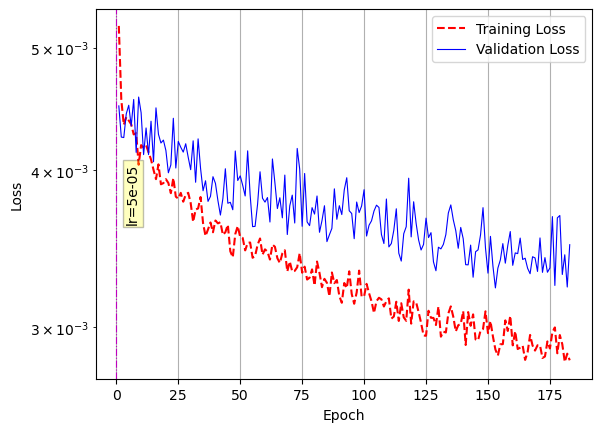

<Figure size 640x480 with 0 Axes>

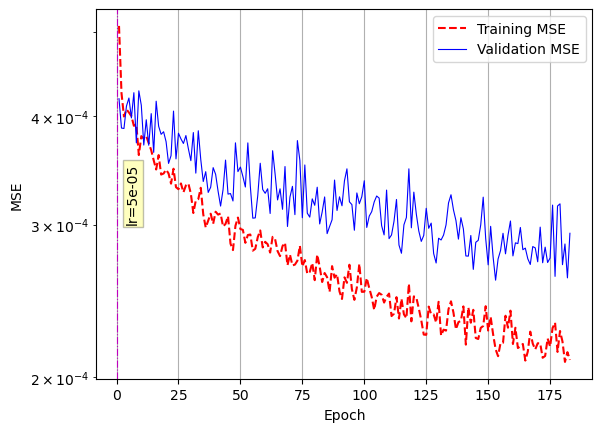

<Figure size 640x480 with 0 Axes>

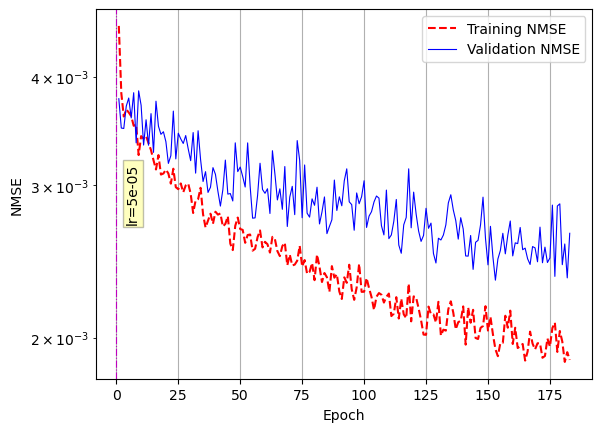

<Figure size 640x480 with 0 Axes>

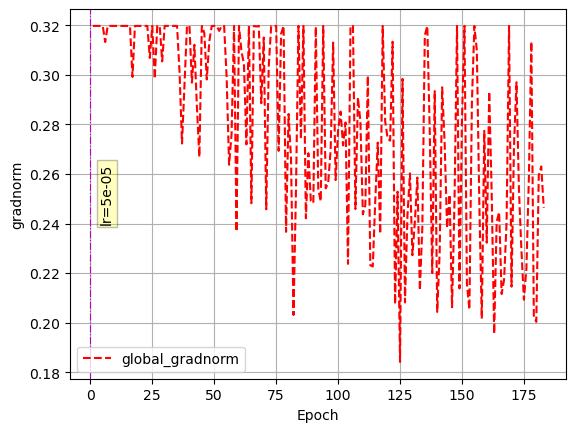



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 30 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.25579802989959716


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
58/58 [==============================] - ETA: 0s - loss: 0.0069 - mse: 9.7084e-04 - NMSE: 0.0087 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.2558 - tot_time: 0h 1m 49.3s

Epoch 1: val_NMSE improved from inf to 0.00884, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_r

Epoch 11/1000
58/58 [==============================] - ETA: 0s - loss: 0.0057 - mse: 7.5764e-04 - NMSE: 0.0068 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.2558 - tot_time: 0h 4m 26.2s

Epoch 11: val_NMSE did not improve from 0.00782
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 15s 265ms/step - loss: 0.0057 - mse: 7.5764e-04 - NMSE: 0.0068 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.2558 - val_loss: 0.0066 - val_mse: 9.1471e-04 - val_NMSE: 0.0082 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/1000
58/58 [==============================] - ETA: 0s - loss: 0.0057 - mse: 7.5850e-04 - NMSE: 0.0068 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.2558 - tot_time: 0h 4m 41.6s

Epoch 12: val_NMSE did not improve from 0.00782
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_03

Epoch 23/1000
58/58 [==============================] - ETA: 0s - loss: 0.0054 - mse: 7.1624e-04 - NMSE: 0.0064 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.2558 - tot_time: 0h 7m 30.9s

Epoch 23: val_NMSE did not improve from 0.00765
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 15s 257ms/step - loss: 0.0054 - mse: 7.1624e-04 - NMSE: 0.0064 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.2558 - val_loss: 0.0065 - val_mse: 9.0313e-04 - val_NMSE: 0.0081 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 24/1000
58/58 [==============================] - ETA: 0s - loss: 0.0054 - mse: 7.0352e-04 - NMSE: 0.0063 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.2558 - tot_time: 0h 7m 46.1s

Epoch 24: val_NMSE did not improve from 0.00765
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_03

Epoch 35/1000
58/58 [==============================] - ETA: 0s - loss: 0.0051 - mse: 6.6122e-04 - NMSE: 0.0060 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.2558 - tot_time: 0h 10m 34.6s

Epoch 35: val_NMSE did not improve from 0.00753
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 15s 266ms/step - loss: 0.0051 - mse: 6.6122e-04 - NMSE: 0.0060 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.2558 - val_loss: 0.0062 - val_mse: 8.5400e-04 - val_NMSE: 0.0077 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 36/1000
58/58 [==============================] - ETA: 0s - loss: 0.0051 - mse: 6.6319e-04 - NMSE: 0.0060 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.2558 - tot_time: 0h 10m 50.1s

Epoch 36: val_NMSE did not improve from 0.00753
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_

Epoch 47/1000
58/58 [==============================] - ETA: 0s - loss: 0.0050 - mse: 6.3746e-04 - NMSE: 0.0057 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.2558 - tot_time: 0h 13m 40.6s

Epoch 47: val_NMSE did not improve from 0.00707
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 15s 267ms/step - loss: 0.0050 - mse: 6.3746e-04 - NMSE: 0.0057 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.2558 - val_loss: 0.0063 - val_mse: 8.6599e-04 - val_NMSE: 0.0078 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 48/1000
58/58 [==============================] - ETA: 0s - loss: 0.0050 - mse: 6.4019e-04 - NMSE: 0.0058 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.2558 - tot_time: 0h 13m 56.2s

Epoch 48: val_NMSE did not improve from 0.00707
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 15s 264ms/step - loss: 0.0049 - mse: 6.2492e-04 - NMSE: 0.0056 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.2558 - val_loss: 0.0062 - val_mse: 8.4021e-04 - val_NMSE: 0.0076 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 60/1000
58/58 [==============================] - ETA: 0s - loss: 0.0048 - mse: 6.0702e-04 - NMSE: 0.0055 - covmat_fro_loss: 9.9608e-04 - global_gradnorm: 0.2558 - tot_time: 0h 16m 58.8s

Epoch 60: val_NMSE did not improve from 0.00707
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 15s 266ms/step - loss: 0.0048 - mse: 6.0702e-04 - NMSE: 0.0055 - covmat_fro_loss: 9.9555e-04 - global_gradnorm: 0.2558 - val_loss: 0.0059 - 

Epoch 72/1000
58/58 [==============================] - ETA: 0s - loss: 0.0047 - mse: 5.8839e-04 - NMSE: 0.0053 - covmat_fro_loss: 9.8415e-04 - global_gradnorm: 0.2558 - tot_time: 0h 20m 1.8s

Epoch 72: val_NMSE did not improve from 0.00707
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 15s 263ms/step - loss: 0.0047 - mse: 5.8839e-04 - NMSE: 0.0053 - covmat_fro_loss: 9.8667e-04 - global_gradnorm: 0.2558 - val_loss: 0.0060 - val_mse: 8.1402e-04 - val_NMSE: 0.0073 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 73/1000
58/58 [==============================] - ETA: 0s - loss: 0.0047 - mse: 5.9422e-04 - NMSE: 0.0053 - covmat_fro_loss: 9.8713e-04 - global_gradnorm: 0.2558 - tot_time: 0h 20m 16.8s

Epoch 73: val_NMSE did not improve from 0.00707
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_

<Figure size 640x480 with 0 Axes>

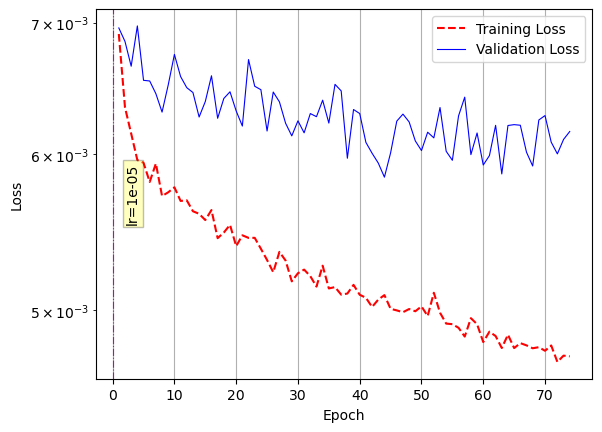

<Figure size 640x480 with 0 Axes>

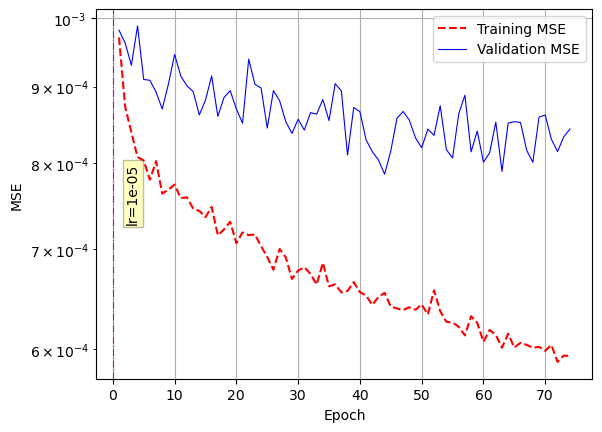

<Figure size 640x480 with 0 Axes>

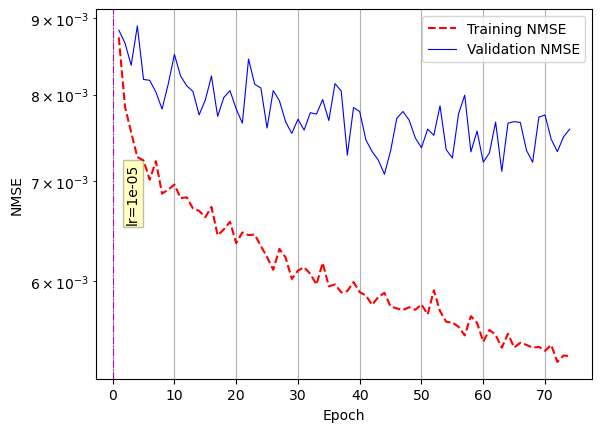

<Figure size 640x480 with 0 Axes>

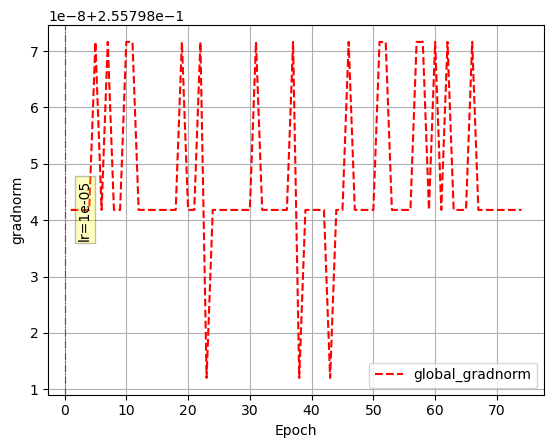



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 50 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.20463845729827881


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
49/49 [==============================] - ETA: 0s - loss: 0.0096 - mse: 0.0020 - NMSE: 0.0176 - covmat_fro_loss: 0.0018 - global_gradnorm: 0.2046 - tot_time: 0h 3m 17.6s

Epoch 1: val_NMSE improved from inf to 0.02080, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/checkpoint-50_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 12/1000
49/49 [==============================] - ETA: 0s - loss: 0.0085 - mse: 0.0017 - NMSE: 0.0151 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.2046 - tot_time: 0h 6m 58.6s

Epoch 12: val_NMSE did not improve from 0.02020
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 20s 405ms/step - loss: 0.0085 - mse: 0.0017 - NMSE: 0.0151 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.2046 - val_loss: 0.0110 - val_mse: 0.0023 - val_NMSE: 0.0203 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 13/1000
49/49 [==============================] - ETA: 0s - loss: 0.0084 - mse: 0.0017 - NMSE: 0.0149 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.2046 - tot_time: 0h 7m 18.6s

Epoch 13: val_NMSE did not improve from 0.02020
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/Lo

Epoch 24/1000
49/49 [==============================] - ETA: 0s - loss: 0.0080 - mse: 0.0016 - NMSE: 0.0140 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.2046 - tot_time: 0h 11m 0.0s

Epoch 24: val_NMSE did not improve from 0.01941
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 20s 406ms/step - loss: 0.0080 - mse: 0.0016 - NMSE: 0.0140 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.2046 - val_loss: 0.0107 - val_mse: 0.0022 - val_NMSE: 0.0198 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 25/1000
49/49 [==============================] - ETA: 0s - loss: 0.0080 - mse: 0.0016 - NMSE: 0.0141 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.2046 - tot_time: 0h 11m 19.9s

Epoch 25: val_NMSE did not improve from 0.01941
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/L

Epoch 37/1000
49/49 [==============================] - ETA: 0s - loss: 0.0077 - mse: 0.0015 - NMSE: 0.0134 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.2046 - tot_time: 0h 15m 21.2s

Epoch 37: val_NMSE did not improve from 0.01941
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 20s 413ms/step - loss: 0.0077 - mse: 0.0015 - NMSE: 0.0134 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.2046 - val_loss: 0.0106 - val_mse: 0.0022 - val_NMSE: 0.0196 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 38/1000
49/49 [==============================] - ETA: 0s - loss: 0.0077 - mse: 0.0015 - NMSE: 0.0134 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.2046 - tot_time: 0h 15m 41.2s

Epoch 38: val_NMSE did not improve from 0.01941
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 21s 422ms/step - loss: 0.0076 - mse: 0.0015 - NMSE: 0.0131 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.2046 - val_loss: 0.0109 - val_mse: 0.0022 - val_NMSE: 0.0201 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 50/1000
49/49 [==============================] - ETA: 0s - loss: 0.0076 - mse: 0.0014 - NMSE: 0.0130 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.2046 - tot_time: 0h 19m 44.1s

Epoch 50: val_NMSE did not improve from 0.01936
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 20s 412ms/step - loss: 0.0076 - mse: 0.0014 - NMSE: 0.0130 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.2046 - val_loss: 0.0107 - val_mse: 0.0022 - val_NM

Epoch 62/1000
49/49 [==============================] - ETA: 0s - loss: 0.0075 - mse: 0.0014 - NMSE: 0.0128 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.2046 - tot_time: 0h 23m 46.9s

Epoch 62: val_NMSE did not improve from 0.01900
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 20s 413ms/step - loss: 0.0075 - mse: 0.0014 - NMSE: 0.0128 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.2046 - val_loss: 0.0106 - val_mse: 0.0022 - val_NMSE: 0.0196 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 63/1000
49/49 [==============================] - ETA: 0s - loss: 0.0074 - mse: 0.0014 - NMSE: 0.0127 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.2046 - tot_time: 0h 24m 6.7s

Epoch 63: val_NMSE did not improve from 0.01900
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/L

Epoch 75/1000
49/49 [==============================] - ETA: 0s - loss: 0.0073 - mse: 0.0014 - NMSE: 0.0125 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.2046 - tot_time: 0h 28m 7.8s

Epoch 75: val_NMSE did not improve from 0.01900
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 20s 411ms/step - loss: 0.0073 - mse: 0.0014 - NMSE: 0.0125 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.2046 - val_loss: 0.0108 - val_mse: 0.0022 - val_NMSE: 0.0201 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 76/1000
49/49 [==============================] - ETA: 0s - loss: 0.0073 - mse: 0.0014 - NMSE: 0.0124 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.2046 - tot_time: 0h 28m 27.7s

Epoch 76: val_NMSE did not improve from 0.01900
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/L

Epoch 88/1000
49/49 [==============================] - ETA: 0s - loss: 0.0072 - mse: 0.0014 - NMSE: 0.0122 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.2046 - tot_time: 0h 32m 28.4s

Epoch 88: val_NMSE did not improve from 0.01900
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 20s 404ms/step - loss: 0.0072 - mse: 0.0014 - NMSE: 0.0122 - covmat_fro_loss: 0.0015 - global_gradnorm: 0.2046 - val_loss: 0.0109 - val_mse: 0.0022 - val_NMSE: 0.0202 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 89/1000
49/49 [==============================] - ETA: 0s - loss: 0.0073 - mse: 0.0014 - NMSE: 0.0123 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.2046 - tot_time: 0h 32m 48.6s

Epoch 89: val_NMSE did not improve from 0.01900
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/

Epoch 101/1000
49/49 [==============================] - ETA: 0s - loss: 0.0071 - mse: 0.0013 - NMSE: 0.0120 - covmat_fro_loss: 0.0015 - global_gradnorm: 0.2046 - tot_time: 0h 36m 49.4s

Epoch 101: val_NMSE did not improve from 0.01900
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 20s 408ms/step - loss: 0.0071 - mse: 0.0013 - NMSE: 0.0120 - covmat_fro_loss: 0.0015 - global_gradnorm: 0.2046 - val_loss: 0.0109 - val_mse: 0.0022 - val_NMSE: 0.0201 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 102/1000
49/49 [==============================] - ETA: 0s - loss: 0.0071 - mse: 0.0013 - NMSE: 0.0119 - covmat_fro_loss: 0.0015 - global_gradnorm: 0.2046 - tot_time: 0h 37m 9.6s

Epoch 102: val_NMSE did not improve from 0.01900
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoin

<Figure size 640x480 with 0 Axes>

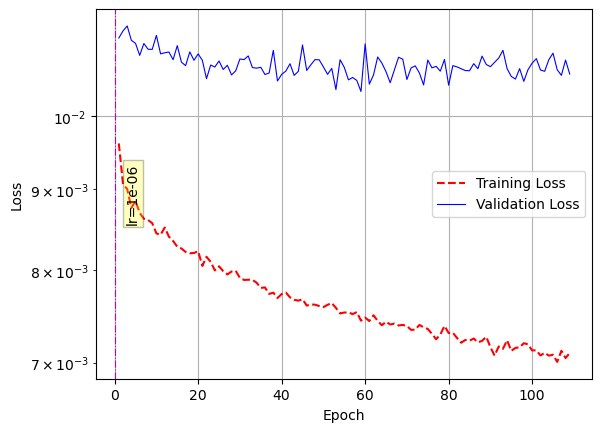

<Figure size 640x480 with 0 Axes>

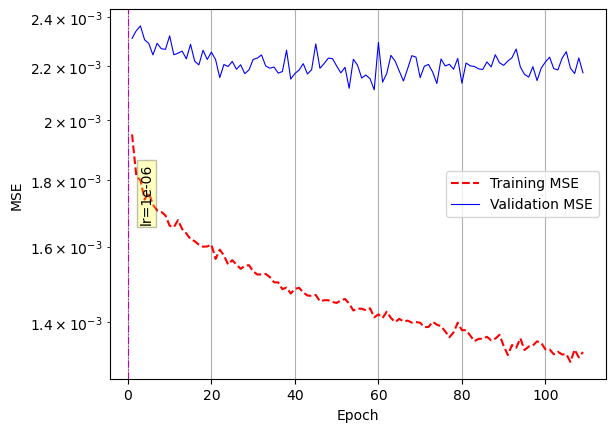

<Figure size 640x480 with 0 Axes>

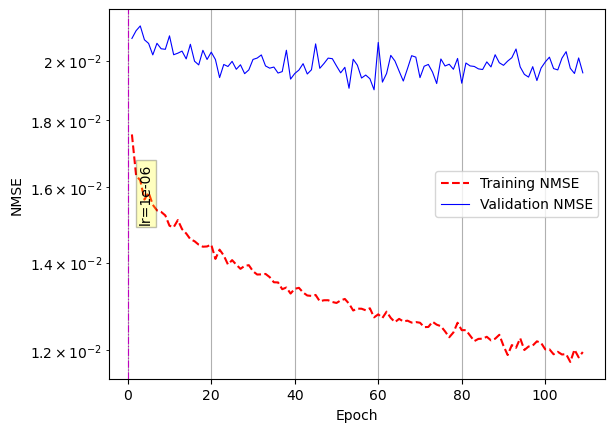

<Figure size 640x480 with 0 Axes>

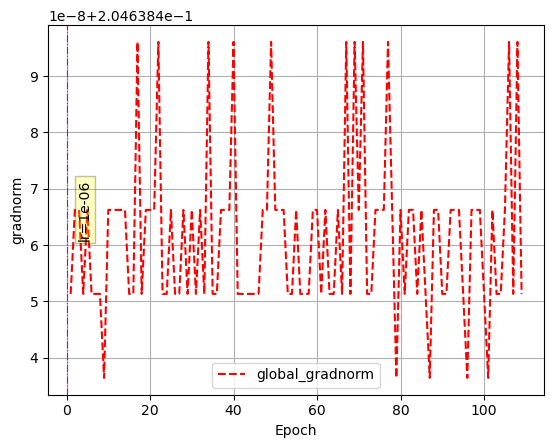



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 70 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.16371079683303835


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 5e-07 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
42/42 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0045 - NMSE: 0.0404 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.1637 - tot_time: 0h 4m 31.1s

Epoch 1: val_NMSE improved from inf to 0.04626, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/checkpoint-70_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 26s 609ms/step - loss: 0.0135 - mse: 0.0039 - NMSE: 0.0349 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.1637 - val_loss: 0.0170 - val_mse: 0.0051 - val_NMSE: 0.0463 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 11/1000
42/42 [==============================] - ETA: 0s - loss: 0.0134 - mse: 0.0039 - NMSE: 0.0349 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.1637 - tot_time: 0h 8m 49.6s

Epoch 11: val_NMSE improved from 0.04503 to 0.04426, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/checkpoint-70_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 26s 628ms/step - loss: 0.0134 

Epoch 23/1000
42/42 [==============================] - ETA: 0s - loss: 0.0129 - mse: 0.0037 - NMSE: 0.0330 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.1637 - tot_time: 0h 14m 4.3s

Epoch 23: val_NMSE did not improve from 0.04426
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 26s 627ms/step - loss: 0.0129 - mse: 0.0037 - NMSE: 0.0330 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.1637 - val_loss: 0.0164 - val_mse: 0.0049 - val_NMSE: 0.0443 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 24/1000
42/42 [==============================] - ETA: 0s - loss: 0.0130 - mse: 0.0037 - NMSE: 0.0335 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.1637 - tot_time: 0h 14m 31.2s

Epoch 24: val_NMSE did not improve from 0.04426
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/L

Epoch 36/1000
42/42 [==============================] - ETA: 0s - loss: 0.0125 - mse: 0.0035 - NMSE: 0.0318 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.1637 - tot_time: 0h 19m 44.4s

Epoch 36: val_NMSE did not improve from 0.04426
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 26s 617ms/step - loss: 0.0125 - mse: 0.0035 - NMSE: 0.0318 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.1637 - val_loss: 0.0167 - val_mse: 0.0050 - val_NMSE: 0.0452 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 37/1000
42/42 [==============================] - ETA: 0s - loss: 0.0122 - mse: 0.0034 - NMSE: 0.0310 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.1637 - tot_time: 0h 20m 10.7s

Epoch 37: val_NMSE did not improve from 0.04426
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/

Epoch 49/1000
42/42 [==============================] - ETA: 0s - loss: 0.0121 - mse: 0.0034 - NMSE: 0.0306 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.1637 - tot_time: 0h 25m 16.9s

Epoch 49: val_NMSE did not improve from 0.04426
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 25s 596ms/step - loss: 0.0121 - mse: 0.0034 - NMSE: 0.0306 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.1637 - val_loss: 0.0167 - val_mse: 0.0050 - val_NMSE: 0.0451 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 50/1000
42/42 [==============================] - ETA: 0s - loss: 0.0122 - mse: 0.0034 - NMSE: 0.0309 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.1637 - tot_time: 0h 25m 41.8s

Epoch 50: val_NMSE did not improve from 0.04426
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_033/checkpoints/

Epoch 61: early stopping


<Figure size 640x480 with 0 Axes>

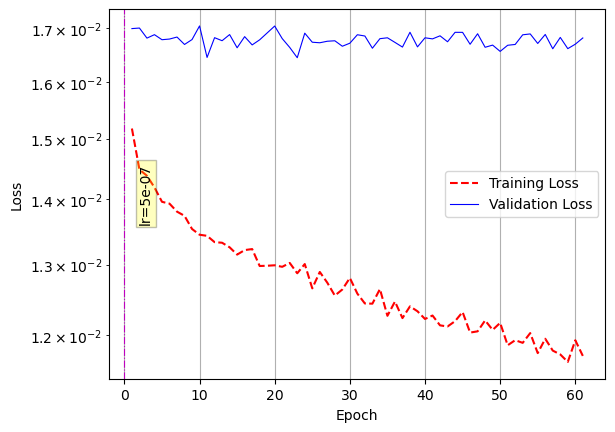

<Figure size 640x480 with 0 Axes>

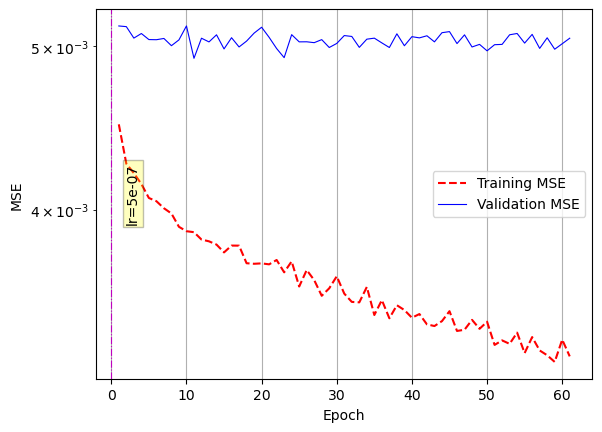

<Figure size 640x480 with 0 Axes>

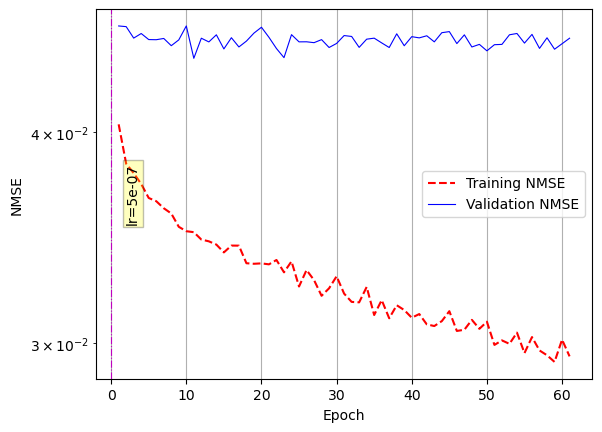

<Figure size 640x480 with 0 Axes>

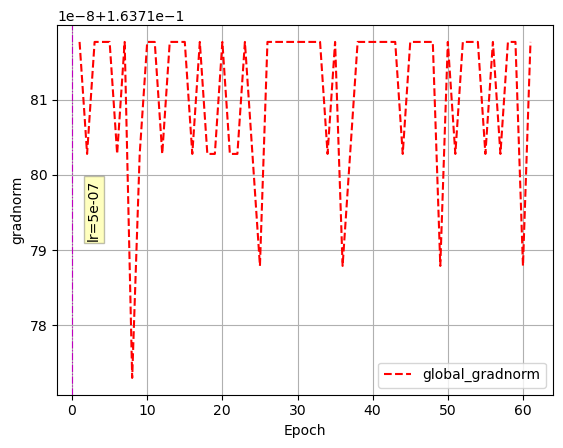

<Figure size 640x480 with 0 Axes>

In [21]:
global_clipnorm = None
for kk in range(len(T_sample_output)):

    num_outsteps = int((T_sample_output[kk] + 0.5*dt_rnn)//dt_rnn)
    if type(freeze_layers) == type(None):
        freeze_layers_thisoutstep = []
    else:
        if kk > len(freeze_layers) - 1:
            freeze_layers_thisoutstep = freeze_layers[-1]
        else:
            freeze_layers_thisoutstep = freeze_layers[kk]
        
        if type(freeze_layers_thisoutstep) == type(None):
            freeze_layers_thisoutstep = []

    total_s_len = 80
    sep_lr_s = ' num_outsteps : {} '.format(num_outsteps)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
    print('\n\n' + '*'*len(sep_lr_s))
    print('' + sep_lr_s+'')
    print('*'*len(sep_lr_s) + '\n\n')

    print('clipnorm : {}, global_clipnorm : {}'.format(clipnorm, global_clipnorm))
    
    trainAERNN(
        create_data_for_RNN,
        Autoencoder,
        AR_RNN,
        all_data,
        AR_AERNN_GRU,
        dt_rnn=dt_rnn,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output[kk],
        T_offset=T_offset,
        boundary_idx_arr=boundary_idx_arr,
        delta_t=delta_t,
        params=params,
        normalize_dataset=normalize_dataset,
        stddev_multiplier=stddev_multiplier,
        skip_intermediate=skip_intermediate,
        normalization_type=normalization_type,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        normalization_constant_arr_rnndata=normalization_arr_rnn,
        learning_rate_list=learning_rate_list[kk],
        epochs=epochs[kk],
        patience=patience[kk],
        loss_weights=loss_weights,
        min_delta=min_delta,
        lambda_reg=lambda_reg,
        stddev_rnn=stddev,
        stateful=False,
        behaviour=behaviour,
        strategy=strategy,
        dir_name_rnn=dir_name_rnn,
        dir_name_AR_AErnn=dir_name_ARrnn,
        batch_size=batch_size,
        load_file_rnn=load_file_rnn,
        wt_file_rnn=wt_file_rnn,
        load_file_ae=load_file_ae,
        wt_file_ae=wt_file_ae,
        covmat_lmda=covmat_lmda,
        readAndReturnLossHistories=readAndReturnLossHistories,
        mytimecallback=mytimecallback,
        plot_losses=plot_losses,
        SaveLosses=SaveLosses,
        train_split=train_split,
        test_split=test_split,
        val_split=val_split,
        freeze_layers=freeze_layers_thisoutstep,
        clipnorm=clipnorm,
        global_clipnorm=global_clipnorm,
    )
    
    wt_file_rnn = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.h5'.format(num_outsteps)
    wt_file_ae = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)
    
    with open(dir_name_ARrnn+'/final_net/losses-{}_outsteps.txt'.format(num_outsteps), 'r') as fl:
        lines = fl.readlines()

    loss_dict = eval(''.join(lines))
    train_global_gradnorm_hist = loss_dict['train_global_gradnorm_hist']
    # lr_change = loss_dict['lr_change']
    # trained_epochs = len(train_global_gradnorm_hist)
    # if lr_change[-1] - lr_change[-2] == epochs[kk][-1]:
    #     global_clipnorm = train_global_gradnorm_hist[-1]
    # else:
    #     global_clipnorm = train_global_gradnorm_hist[-patience[kk][-1]]

    # alpha1 = 0.9
    # alpha2 = 0.1
    # global_clipnorm = train_global_gradnorm_hist[0]
    # for i in range(1, len(train_global_gradnorm_hist)):
    #     global_clipnorm = alpha1*global_clipnorm + alpha2*train_global_gradnorm_hist[i]

    grad_norm_decay = 0.8
    idxs_to_ignore = 0

    global_clipnorm = np.max(train_global_gradnorm_hist[idxs_to_ignore:])
    # global_clipnorm = 0.25 * np.round(4*global_clipnorm)
    global_clipnorm = grad_norm_decay * global_clipnorm

In [22]:
a = 123e-5
a

0.00123

In [23]:
s = '{:E}'.format(a)
s

'1.230000E-03'

In [24]:
idx = s.find('E')
num = float(s[0:idx])
10**float(s[idx+1:])

0.001

In [25]:
### Training the combined AE-RNN


# 